# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from contextlib import nullcontext

In [2]:
df = pd.read_csv("facial-keypoints-detection/training.csv")

In [3]:
y_full = df.drop(columns=["Image"]).values.astype(np.float32)
x_full = [[int(n) for n in img_str.split()] for img_str in df["Image"]]
x_full = np.array(x_full, dtype=np.float32).reshape((-1, 1, 96, 96)) / 255

In [4]:
def plot(img, keypoint_sets):
    plt.imshow(img, cmap="grey")
    for y in keypoint_sets:
        key_points = y.reshape((-1, 2))
        plt.scatter(key_points[:, 0], key_points[:, 1])
    plt.axis('off')
    plt.show()

In [5]:
def multi_plot(imgs, key_point_sets, cols=4):
    n = len(imgs)
    rows = (n + cols - 1) // cols
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(imgs[i], cmap="grey")
        plt.axis('off')
        key_points = key_point_sets[i].reshape((-1, 2))
        key_points *= imgs.shape[1] / 96
        plt.scatter(key_points[:, 0], key_points[:, 1], s=8, c="lime")
    plt.tight_layout()
    plt.show()

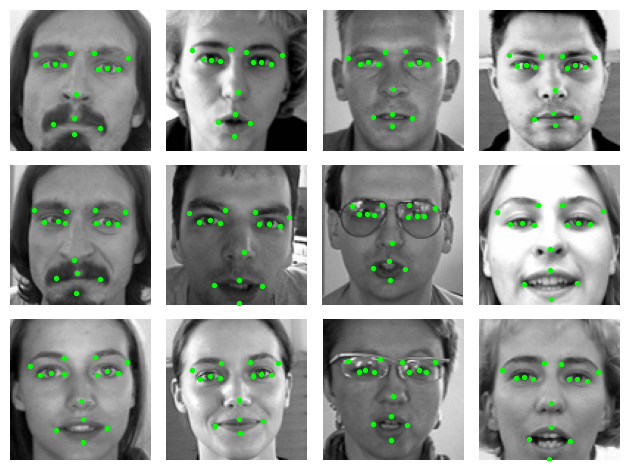

In [6]:
multi_plot(x_full[:12, 0], y_full[:12])

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_full, 
    y_full,
    test_size=0.125,
    shuffle=True,
    random_state=0,
)

imputer = KNNImputer()
y_train_full = imputer.fit_transform(y_train_full)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, 
    y_train_full,
    test_size=0.15,
    shuffle=True,
    random_state=0,
)

print(f"{len(x_train)} train, {len(x_val)} val, {len(x_test)} test")

5241 train, 926 val, 882 test


# Default Model

In [8]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [9]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

compile_model = device == "cpu" or device == "cuda"

context = torch.autocast(device) if device == "cuda" else nullcontext()

In [10]:
def np2torch(x, device=device):
    return torch.from_numpy(x).to(device)


def torch2np(x):
    return x.detach().cpu().numpy()

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 30)


    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = x.reshape((-1, 9216))
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [12]:
def batch_iterate(x, y, batch_size, device=device):
    permutation = np.random.permutation(y.shape[0])
    for s in range(0, y.shape[0], batch_size):
        idxs = permutation[s:s + batch_size]
        yield np2torch(x[idxs], device), np2torch(y[idxs], device)

In [13]:
def evaluate(model, x, y, device=device):
    model.eval()
    loss_sum = 0
    r2_sum = 0
    n_batches = 0
    for x, y in batch_iterate(x, y, batch_size=100, device=device):
        y_pred = model(x)
        loss = F.mse_loss(y_pred, y).item()
        var = torch.mean(torch.square(y - torch.mean(y, dim=0))).item()
        r2 = 1 - loss / var
        loss_sum += loss
        r2_sum += r2
        n_batches += 1
    print(f"loss: {loss_sum / n_batches:.3f}, R^2: {r2_sum / n_batches:.3f}")

In [14]:
model = CNN().to(device)
if compile_model:
    model = torch.compile(model)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

In [15]:
# model.train()

# for epoch in range(200):
#     if (epoch + 1) % 10 == 0:
#         print('epoch:', epoch + 1)

#     for x, y in batch_iterate(x_train, y_train, batch_size=100):
#         optimizer.zero_grad()
#         with context:
#             loss = F.mse_loss(model(x), y)
#         loss.backward()
#         optimizer.step()

#     scheduler.step()
    
# torch.save(model.state_dict(), "checkpoints/model0.pth")

In [16]:
model.load_state_dict(torch.load("checkpoints/model_good.pth"))

<All keys matched successfully>

In [17]:
print("train:", end="\n    ")
evaluate(model, x_train, y_train)
print("val:", end="\n    ")
evaluate(model, x_val, y_val)

train:
    loss: 3.227, R^2: 0.713
val:
    loss: 4.603, R^2: 0.575


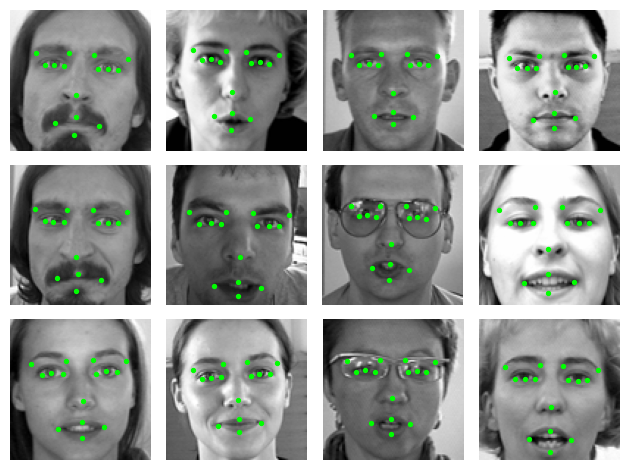

In [18]:
y_pred = torch2np(model(np2torch(x_full[:12])).clip(0, 95))
multi_plot(x_full[:12, 0], y_pred[:12])

# Attacking the Model

In [19]:
def fgsm(model, x, y, eps):
    delta = torch.zeros_like(x, requires_grad=True)
    with context:
        loss = F.mse_loss(model(x + delta), y)
    loss.backward()
    return eps * torch.sign(delta.grad)

In [20]:
def pgd(model, x, y, eps, alpha=0.5, n_iters=50):
    delta = torch.zeros_like(x, requires_grad=True)
    for _ in range(n_iters):
        with context:
            loss = F.mse_loss(model(x + delta), y)
        loss.backward()
        with torch.no_grad():
            delta += alpha * delta.grad
            delta.clip_(-eps, eps)
            delta.grad.zero_()
    return delta.detach()

In [21]:
def evaluate_fgsm(model, x, y, eps, device=device):
    model.eval()
    loss_sum = 0
    r2_sum = 0
    n_batches = 0
    for x, y in batch_iterate(x, y, batch_size=100, device=device):
        x += fgsm(model, x, y, eps)
        y_pred = model(x)
        loss = F.mse_loss(y_pred, y).item()
        var = torch.mean(torch.square(y - torch.mean(y, dim=0))).item()
        r2 = 1 - loss / var
        loss_sum += loss
        r2_sum += r2
        n_batches += 1
    print(f"loss: {loss_sum / n_batches:.3f}, R^2: {r2_sum / n_batches:.3f}")

In [22]:
def evaluate_pgd(model, x, y, eps, device=device):
    model.eval()
    loss_sum = 0
    r2_sum = 0
    n_batches = 0
    for x, y in batch_iterate(x, y, batch_size=100, device=device):
        x += pgd(model, x, y, eps)
        y_pred = model(x)
        loss = F.mse_loss(y_pred, y).item()
        var = torch.mean(torch.square(y - torch.mean(y, dim=0))).item()
        r2 = 1 - loss / var
        loss_sum += loss
        r2_sum += r2
        n_batches += 1
    print(f"loss: {loss_sum / n_batches:.3f}, R^2: {r2_sum / n_batches:.3f}")

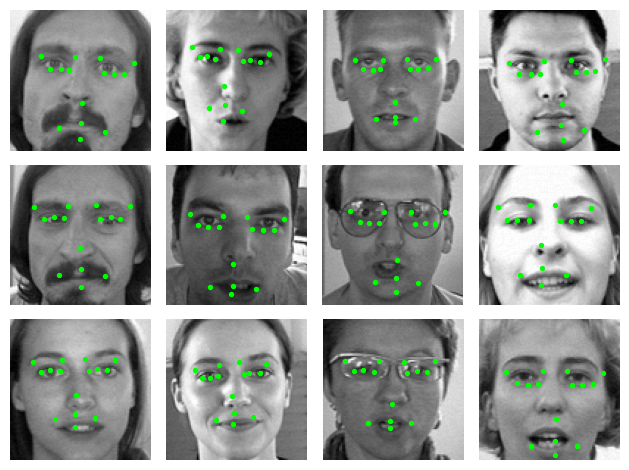

In [23]:
delta = fgsm(model, np2torch(x_full[:12]), np2torch(y_full[:12]), 0.01)
y_pred = torch2np(model(np2torch(x_full[:12]) + delta).clip(0, 95))
multi_plot(x_full[:12, 0] + torch2np(delta)[:12, 0], y_pred[:12])

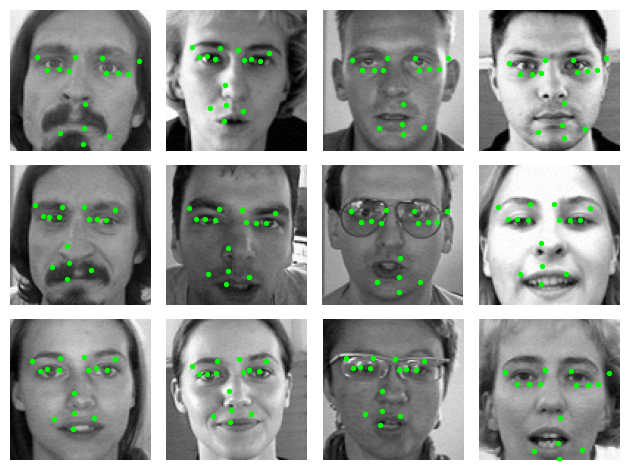

In [24]:
delta = pgd(model, np2torch(x_full[:12]), np2torch(y_full[:12]), 0.01)
y_pred = torch2np(model(np2torch(x_full[:12]) + delta).clip(0, 95))
multi_plot(x_full[:12, 0] + torch2np(delta)[:12, 0], y_pred[:12])

In [25]:
print("no attack:", end="\n    ")
evaluate(model, x_val, y_val)
print("fgsm attack:", end="\n    ")
evaluate_fgsm(model, x_val, y_val, 0.01)
print("pgd attack:", end="\n    ")
evaluate_pgd(model, x_val, y_val, 0.01)

no attack:
    loss: 4.597, R^2: 0.571
fgsm attack:
    loss: 29.064, R^2: -1.800
pgd attack:
    loss: 65.954, R^2: -5.304


# Robust Model FGSM

In [26]:
robust_model_fgsm = CNN().to(device)
if compile_model:
    robust_model_fgsm = torch.compile(robust_model_fgsm)

optimizer = optim.Adam(robust_model_fgsm.parameters(), lr=0.001, weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)

In [27]:
# robust_model_fgsm.train()

# eps = 0.005
# batch_size = 100
# delta = torch.zeros((batch_size, 1, 96, 96), requires_grad=True, device=device)

# for epoch in range(200):
#     if (epoch + 1) % 10 == 0:
#         print('epoch:', epoch + 1)
        
#     for x, y in batch_iterate(x_train, y_train, batch_size=batch_size):
#         if len(x) != batch_size:
#             continue

#         optimizer.zero_grad()
#         with context:
#             loss = F.mse_loss(robust_model_fgsm(x + delta), y)
#         loss.backward()
#         optimizer.step()

#         with torch.no_grad():
#             x += eps * delta.grad.sign_()
#             delta.grad.zero_()

#         optimizer.zero_grad()
#         with context:
#             loss = F.mse_loss(robust_model_fgsm(x), y)
#         loss.backward()
#         optimizer.step()
    
#     eps += 0.0001
#     scheduler.step()
    
# torch.save(robust_model_fgsm.state_dict(), "checkpoints/robust_model_fgsm0.pth")

In [28]:
robust_model_fgsm.load_state_dict(torch.load("checkpoints/robust_model_fgsm_good.pth"))

<All keys matched successfully>

In [29]:
print("no attack:", end="\n    ")
evaluate(robust_model_fgsm, x_val, y_val)
print("fgsm attack:", end="\n    ")
evaluate_fgsm(robust_model_fgsm, x_val, y_val, 0.01)
print("pgd attack:", end="\n    ")
evaluate_pgd(robust_model_fgsm, x_val, y_val, 0.01)

no attack:
    loss: 4.461, R^2: 0.590
fgsm attack:
    loss: 8.848, R^2: 0.345
pgd attack:
    loss: 14.156, R^2: -0.332


# Robust PGD Fine Tuning

In [30]:
def pgd_loss(model, x, y, eps, device=device):
    model.eval()
    loss_sum = 0
    n_batches = 0
    for x, y in batch_iterate(x, y, batch_size=100, device=device):
        x += pgd(model, x, y, eps)
        y_pred = model(x)
        loss = F.mse_loss(y_pred, y).item()
        loss_sum += loss
        n_batches += 1
    return loss_sum / n_batches

In [31]:
robust_model_pgd = CNN().to(device)
robust_model_pgd.load_state_dict(torch.load("checkpoints/robust_model_fgsm_good.pth"))
if compile_model:
    robust_model_pgd = torch.compile(robust_model_pgd)

optimizer = optim.Adam(robust_model_pgd.parameters(), lr=0.0001, weight_decay=0.1)

In [32]:
# robust_model_pgd.train()

# eps = 0.01
# batch_size = 100
# epochs_per_pgd_training = 5

# best_pgd_val_loss = pgd_loss(robust_model_pgd, x_val, y_val, eps)
# print(f"before pgd training, loss: {best_pgd_val_loss:.3f}")

# for epoch in range(50):
#     for x, y in batch_iterate(x_train, y_train, batch_size=batch_size):
#         optimizer.zero_grad()
#         with context:
#             loss = F.mse_loss(robust_model_pgd(x), y)
#         loss.backward()
#         optimizer.step()

#         x += pgd(robust_model_pgd, x, y, eps)
#         optimizer.zero_grad()
#         with context:
#             loss = F.mse_loss(robust_model_pgd(x), y)
#         loss.backward()
#         optimizer.step()
    
#     if (epoch + 1) % 5 == 0:
#         pgd_val_loss = pgd_loss(robust_model_pgd, x_val, y_val, eps)
#         print(f"epoch {epoch + 1}, loss: {pgd_val_loss:.3f}")
#         if pgd_val_loss < best_pgd_val_loss:
#             best_pgd_val_loss = pgd_val_loss
#             torch.save(robust_model_pgd.state_dict(), "checkpoints/robust_model_pgd0.pth")
#             print("    model saved")
#         else:
#             break

In [33]:
robust_model_pgd.load_state_dict(torch.load("checkpoints/robust_model_pgd_good.pth"))

<All keys matched successfully>

In [34]:
print("no attack:", end="\n    ")
evaluate(robust_model_pgd, x_val, y_val)
print("fgsm attack:", end="\n    ")
evaluate_fgsm(robust_model_pgd, x_val, y_val, 0.01)
print("pgd attack:", end="\n    ")
evaluate_pgd(robust_model_pgd, x_val, y_val, 0.01)

no attack:
    loss: 4.058, R^2: 0.623
fgsm attack:
    loss: 6.247, R^2: 0.422
pgd attack:
    loss: 6.042, R^2: 0.430


# Testing Examples

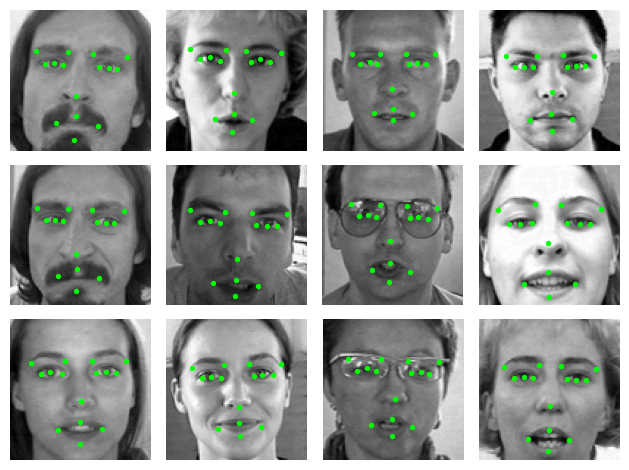

In [35]:
delta = fgsm(robust_model_pgd, np2torch(x_full[:12]), np2torch(y_full[:12]), 0.01)
y_pred = torch2np(robust_model_pgd(np2torch(x_full[:12]) + delta).clip(0, 95))
multi_plot(x_full[:12, 0] + torch2np(delta)[:12, 0], y_pred[:12])

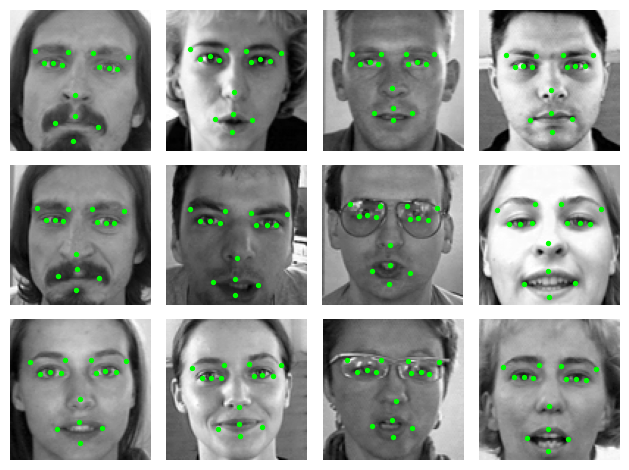

In [36]:
delta = pgd(robust_model_pgd, np2torch(x_full[:12]), np2torch(y_full[:12]), 0.01)
y_pred = torch2np(robust_model_pgd(np2torch(x_full[:12]) + delta).clip(0, 95))
multi_plot(x_full[:12, 0] + torch2np(delta)[:12, 0], y_pred[:12])